## Distribution of the inverse index

In [1]:
%matplotlib inline
%load_ext memory_profiler
from neighborsMinHash import MinHash
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score


In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
%time %memit datasetBursi = vectorizer.transform( graphs )

peak memory: 277.86 MiB, increment: 184.19 MiB
CPU times: user 17.2 s, sys: 76 ms, total: 17.2 s
Wall time: 18.3 s


In [3]:
n_neighbors_minHash = MinHash(number_of_hash_functions=400, shingle_size = 1, similarity=True, bloomierFilter=False, number_of_cores=2)
n_neighbors_minHash.fit(datasetBursi)

In [4]:
distribution = n_neighbors_minHash.get_distribution_of_inverse_index()
min_ = min(distribution[0])
max_ = max(distribution[0])

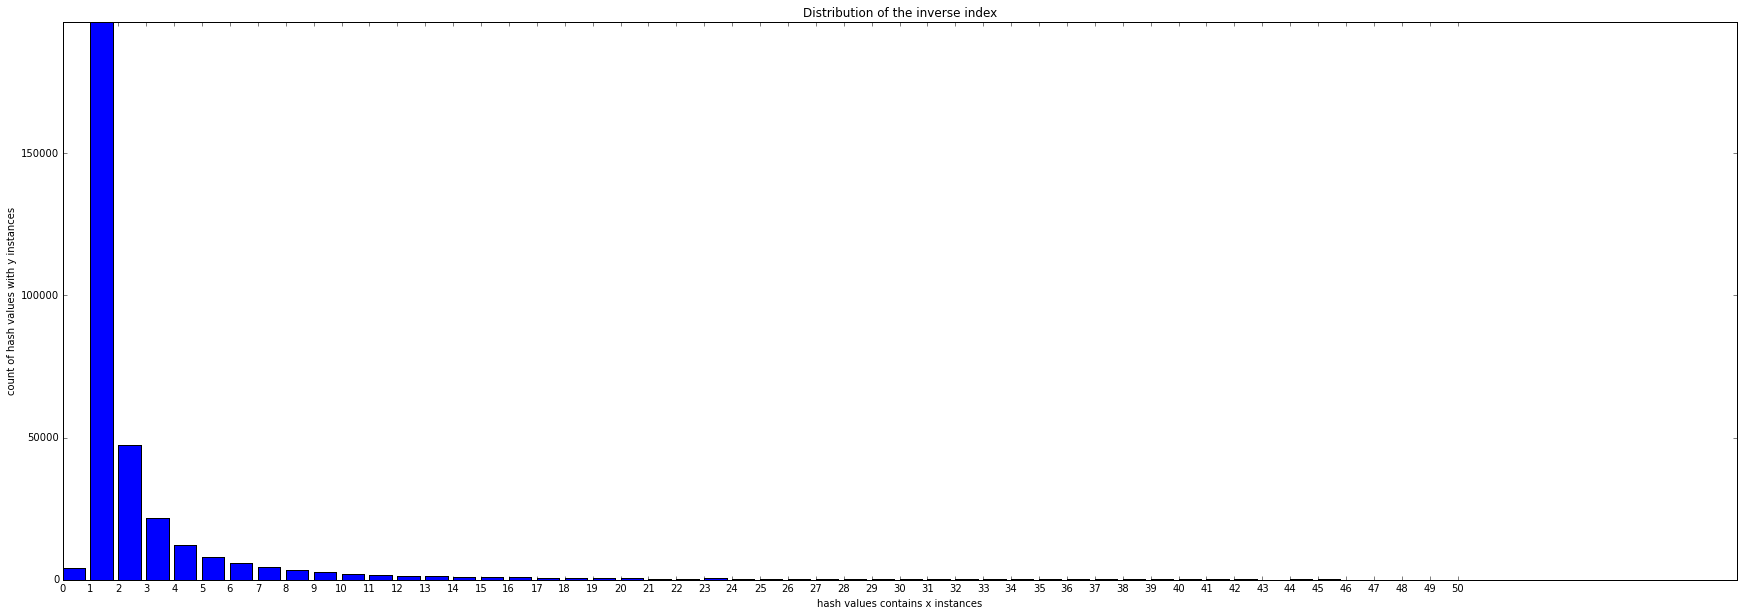

In [5]:
X = np.arange(len(distribution[0]))
plt.figure(figsize=(30, 10))
plt.bar(X, distribution[0].values())
plt.xticks(X, distribution[0].keys())
ymax = max(distribution[0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.show()

### Influence to the accuracy if instances with a count of n are removed

In [31]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def createPlot(x_values_list, accuracy, time_fit, time_kneighbors, xlabel, ylabelAccuracy, ylabelFit, ylabelKneighbors,
              mean=None, std=None):
    plt.figure(figsize=(20, 20))
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    if mean != None:
        par3 = host.twinx()
        par3.plot((mean, min(accuracy)), (mean, min(accuracy)), 'k-')
        par4 = host.twinx()
        par4.plot((std, min(accuracy)), (std, min(accuracy)), 'k-')

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    p1, = host.plot(x_values_list, accuracy, "b-")
    p2, = par1.plot(x_values_list, time_fit, "r-")
    p3, = par2.plot(x_values_list, time_kneighbors, "g-")

    host.set_xlim(min(x_values_list), max(x_values_list))
    host.set_ylim(min(accuracy), max(accuracy))
    par1.set_ylim(min(time_fit), max(time_fit))
    par2.set_ylim(min(time_kneighbors), max(time_kneighbors))

    host.set_xlabel(xlabel)
    host.set_ylabel(ylabelAccuracy)
    par1.set_ylabel(ylabelFit)
    par2.set_ylabel(ylabelKneighbors)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    
       
#     host.legend(lines, [l.get_label() for l in lines])

    plt.show()

In [7]:
import time
prune_value = 51
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
accuracy_ = []
time_fit_ = []
time_kneighbors_ = []
for prune_less_as in xrange(prune_value):
    n_neighbors_minHash_prune = MinHash(number_of_hash_functions=400, shingle_size = 1, similarity=True, bloomierFilter=False, number_of_cores=2, prune_inverse_index=prune_less_as)
    time_start = time.time()
    n_neighbors_minHash_prune.fit(datasetBursi)
    time_end = time.time() - time_start
    time_fit_.append(time_end)
    time_start = time.time()
    neighbors = n_neighbors_minHash_prune.kneighbors(return_distance=False, fast=False)
    time_end = time.time() - time_start
    time_kneighbors_.append(time_end)
    accuracy_value = 0
    for x, y in zip(neighbors, neighbors_sklearn):
        accuracy_value += accuracy_score(x, y)
    accuracy_.append(accuracy_value / len(neighbors))

In [9]:
print len(accuracy_)
print len(time_fit_)
print len(time_kneighbors_)
print len(range(prune_value))

51
51
51
51


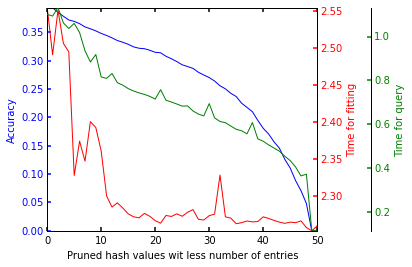

In [17]:
createPlot(range(prune_value), accuracy_, time_fit_, time_kneighbors_, "Pruned hash values wit less number of entries", "Accuracy",
           "Time for fitting", "Time for query")

In [12]:
min_value = min(distribution[1])
max_value = max(distribution[1])
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
accuracy = []
time_fit = []
time_kneighbors = []
for value in sorted(distribution[1]):
    n_neighbors_minHash_prune = MinHash(number_of_hash_functions=400, shingle_size = 1, similarity=True, 
                                        bloomierFilter=False, number_of_cores=2, 
                                        prune_inverse_index=-1, prune_inverse_index_after_instance=-1,
                                        removeHashFunctionWithLessEntriesAs=value)
    time_start = time.time()
    n_neighbors_minHash_prune.fit(datasetBursi)
    time_end = time.time() - time_start
    time_fit.append(time_end)
    time_start = time.time()
    neighbors = n_neighbors_minHash_prune.kneighbors(return_distance=False, fast=False)
    time_end = time.time() - time_start
    time_kneighbors.append(time_end)
    accuracy_value = 0
    for x, y in zip(neighbors, neighbors_sklearn):
        accuracy_value += accuracy_score(x, y)
    accuracy.append(accuracy_value / len(neighbors))

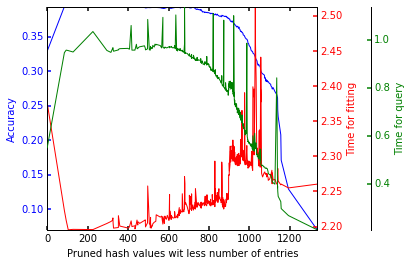

In [32]:
createPlot(sorted(distribution[1]), accuracy, time_fit, time_kneighbors, "Pruned hash values wit less number of entries",
           "Accuracy", "Time for fitting", "Time for query")

In [25]:
print "Mean: ", distribution[4]

Mean:  324385


In [26]:
print "std: ", distribution[5]

std:  0
